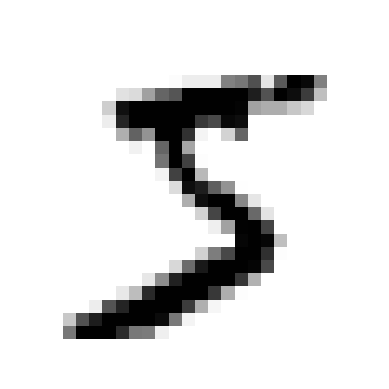

In [1]:
# Ch 3: Classification — Step-by-Step in Python

# Load and visualize MNIST data

from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"]
y = y.astype(int)

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()


In [9]:
# Train a binary classifier - is it a 5?

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

y_binary = (y == 5)
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

clf = SGDClassifier(random_state=42)
clf.fit(X_train, y_train)
print("Prediction:", clf.predict([some_digit]))  # True if 5

y [5 0 4 ... 4 5 6]
Prediction: [False]


In [10]:
# Performance evaluation

from sklearn.model_selection import cross_val_score

accuracy = cross_val_score(clf, X_train, y_train, cv=3, scoring="accuracy")
print("Cross-validated Accuracy:", accuracy.mean())


Cross-validated Accuracy: 0.9669105953211604


In [11]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(clf, X_train, y_train, cv=3)
conf_matrix = confusion_matrix(y_train, y_train_pred)
print(conf_matrix)

[[50287   673]
 [ 1180  3860]]


In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision:", precision_score(y_train, y_train_pred))
print("Recall:", recall_score(y_train, y_train_pred))
print("F1 Score:", f1_score(y_train, y_train_pred))

Precision: 0.8515332009706597
Recall: 0.7658730158730159
F1 Score: 0.8064347644416588


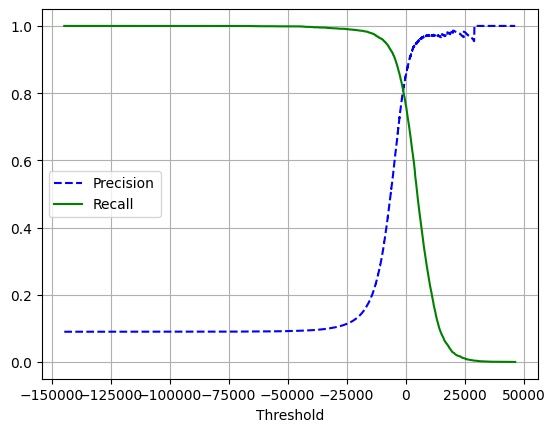

In [14]:
# Precision-Recall curve and ROC

# Precision: Of all predicted 5s, how many were correct?
# Recall: Of all actual 5s, how many did we catch?
# F1 score offers the best balance between precision and recall

from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(clf, X_train, y_train, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

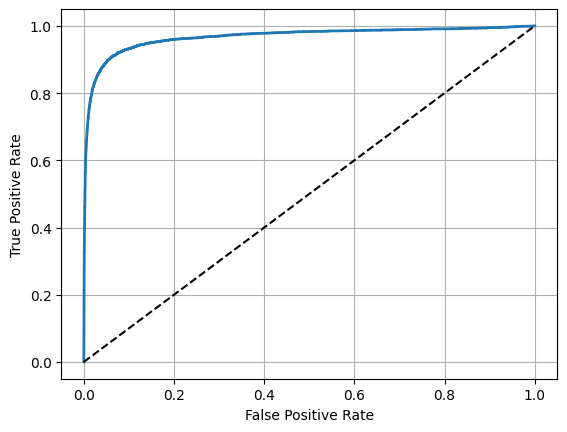

AUC Score: 0.9672937302210262


In [15]:
from sklearn.metrics import roc_curve, roc_auc_score

# True Positive Rate (TPR) = Recall = How many actual 5s are correctly predicted.
# False Positive Rate (FPR) = How many not-5s incorrectly labeled as 5.

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], "k--")  # Random guess line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()

plot_roc_curve(fpr, tpr)

# Area Under Curve (AUC) summarizes model quality:
# AUC = 1.0 → Perfect classifier
# AUC = 0.5 → Random guessing
# AUC > 0.9 → Excellent
# AUC between 0.7–0.9 → Fair to good
# AUC < 0.7 → Needs improvement

print("AUC Score:", roc_auc_score(y_train, y_scores))

In [17]:
# Multiclass classification
# Classifying all digits (0-9)

#Logistic Regression assumes all features are on a similar scale. 
# But digit pixel values (like in MNIST) range from 0–255, which can cause optimization trouble.

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

log_clf = LogisticRegression(solver="lbfgs", max_iter=5000)
log_clf.fit(X_train_scaled, y_train)

some_digit_scaled = scaler.transform([some_digit.astype(np.float64)])
print("Predicted:", log_clf.predict(some_digit_scaled)[0])


Predicted: True


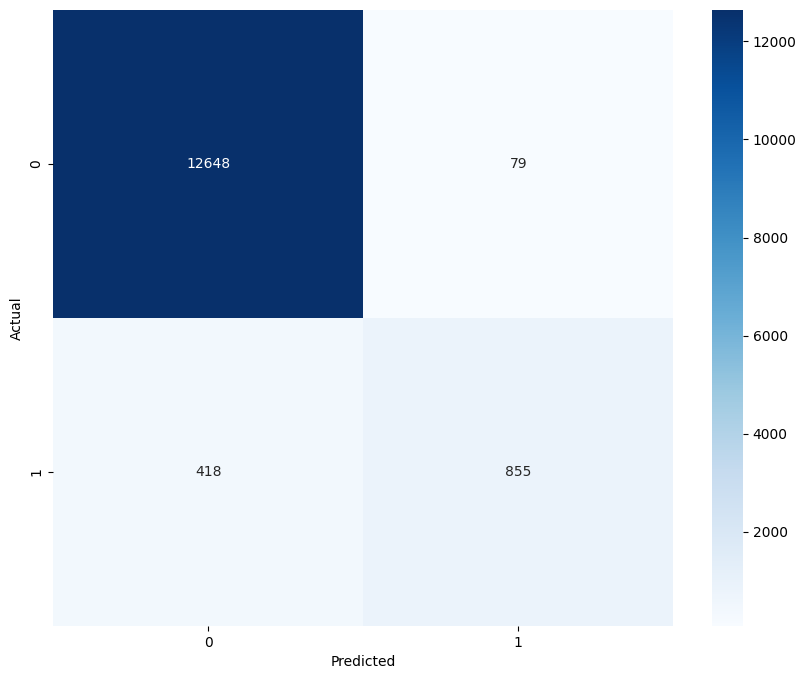

In [19]:
# Error analysis with confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns

y_test_pred = log_clf.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# High TN count (12,648) shows the model is excellent at detecting class 0.
# Good TP count (855), but many FNs (418) shows the model misses many actual class 1s.
Accuracy = TP/(TP+TN)
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
F1_score = (Precision*Recall)(Precision+Recall)

In [24]:
# Multilabel classification (large? even?)

from sklearn.neighbors import KNeighborsClassifier

y_multilabel_full = np.c_[(y >= 7), (y % 2 == 0)]

X_train, X_test, y_train_ml, y_test_ml = train_test_split(X, y_multilabel_full, test_size=0.2, random_state=42)

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train_ml)

print("Predicted (Large, Even):", knn_clf.predict([some_digit]))

Predicted (Large, Even): [[False False]]


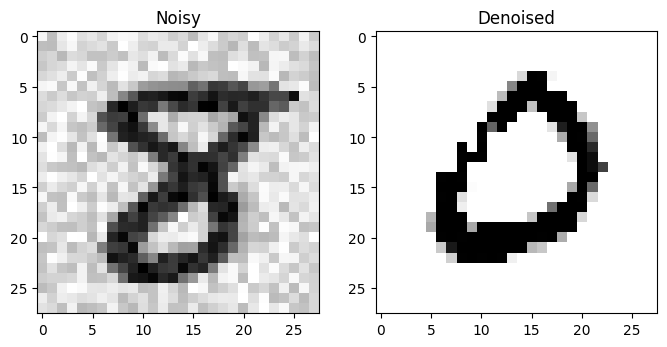

In [28]:
# Multi-output classification: Image Denoising

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
y_train_mod = X_train

noise_test = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise_test
y_test_mod = X_test

knn_cleaner = KNeighborsClassifier()
knn_cleaner.fit(X_train_mod, y_train_mod)

clean_digit = knn_cleaner.predict([X_test_mod[5]])

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Noisy")
plt.imshow(X_test_mod[0].reshape(28, 28), cmap="binary")

plt.subplot(1, 2, 2)
plt.title("Denoised")
plt.imshow(clean_digit.reshape(28, 28), cmap="binary")
plt.show()
